In [1]:
import sys,os
import numpy as np
import pylab as py
from scipy.interpolate import interp2d
from scipy.interpolate import RectBivariateSpline
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.integrate import quad,dblquad,fixed_quad
from numba.decorators import jit, autojit

In [2]:
#root='../'
import sys,os
import numpy as np
#sys.path.insert(1,root)
#from tools import tex,checkdir,load,save,fill_between,com
import pylab as py
import matplotlib.gridspec as gridspec
from  matplotlib import rc
%matplotlib inline  
%config InlineBackend.figure_format = 'retina'  
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text',usetex=True)
import pandas as pd
from scipy import stats
from scipy.integrate import quad,fixed_quad
from scipy.optimize import root,leastsq,minimize
#from PDF.CT10 import CT10
#from numba import jit,autojit

In [9]:
#DBC--this class will read and partition the ct10 PDS files
#	a seperate file will allow for calculations with the 
#	PDFs.

class CT10(object):

  def __init__(self,root='../',filename='ct10.00.pds'):
    """
    Read and parse CT10.pds. May work with other 
    CTEQ pds files, but there is no guarantee.
    """
    self.D = {}
    self.fname = root+'/'+filename
    self._load_PDSfile()
    self.get_interpolators()

  def _load_PDSfile(self):
    
    #read file
    stream0 = open(self.fname, 'r') #external file read in
    inStream = stream0.readlines() #internal stream after read
    stream0.close()
      
    # convert loaded file to floats
    inStream = [i.strip() for i in inStream]
    self.fitName = inStream[0] #name of pdf fit
    
    temp4 = inStream[4].replace('d', 'E') # fix fortran formating
    temp4 = temp4.split()
    
    alphaQ = float(temp4[1]) #alph_S(M_Z) for this fit
    Qalpha = float(temp4[2]) # M_Z 
    self.mxFlav = int(temp4[3]) # maximum number of flavors
    self.valFlav = int(temp4[4]) # number of valance flavors
    #a, q, m, v = map(float, temp4) #LOOK UP MAP COMMAND
    #A, B, C, D, = ARRAY # EXTRA COMMA FOR DIFFERENT SIZED ARRAYS
    temp6 = inStream[6].split() 
    nx = int(temp6[0]) # number of x points in grid
    nt = int(temp6[1]) # number of qpoints in grid
    ng = int(temp6[3]) # number of additional lines for fit parameters
    startLine = 10 + ng # MAY NOT BE NECCESSARY
    stopLine = startLine+nt # MAY NOT BE NECCESSARY
    tempXX = inStream[startLine].split()
    self.qMin = float(tempXX[0])
    self.qMax = float(tempXX[1])
    
    # populate list of Q values
    qList=[None]*(nt + 1)
    for q in range(0, len(qList)):
      qtemp = inStream[startLine + q].split()
      qList[q] = float(qtemp[0])
      
    #populate list of x values
    xMinMax = inStream[stopLine + 2].split()
    self.xMin = float(xMinMax[0])
    xCount = 1 # set to one because of artificial zero point
    xLineCount = 0
    xList = [float(0.0)] # artificial zero to get number of x points correct
    firstXline = stopLine + 3
    
    while xCount < nx:
      tempXline = inStream[firstXline + xLineCount].split()
      xLineLength = len(tempXline)
      #tempXpts = [None]*xLineLength
      for xpt in range(0, xLineLength):
        xList.append(float(tempXline[xpt]))
      xLineCount = xLineCount + 1
      xCount = xCount + xLineLength
      
    #populate PDF grid
    firstGridLine = firstXline + xLineCount+1
    pdfGrid = []
    pdfCount = 0
    pdfLineCount = 0
    numBlocks = (nx + 1)*(nt + 1)
    numFlav = self.mxFlav + 1 + self.valFlav
    numPoints = numBlocks*numFlav
    
    while pdfCount < numPoints:
      tempPDFline = inStream[firstGridLine + pdfLineCount].split()
      pdfLineLength = len(tempPDFline)
      for  gridpt in range(0, pdfLineLength):
        pdfGrid.append(float(tempPDFline[gridpt]))
      pdfLineCount = pdfLineCount + 1
      pdfCount = pdfCount + pdfLineLength
      
    outGrid = np.reshape(pdfGrid, (numFlav, nt + 1, nx + 1))
    self.fileArray = [xList, qList, outGrid]
    
  def displayName(self):
    """displayName(): Returns basic infromation about the loaded PDF grid."""
    s = 'The file contains PDF set ' + repr(self.fitName)
    t = ' and contains ' + repr(self.mxFlav) 
    r = ' flavors and ' + repr(self.valFlav)
    i = ' valance flavors. '
    print s + t + r + i 
    #s = "{} and {} suck".format("Flo", "Ben")

  def _findPartonIndex(self):
    if self.ipart >= -self.mxFlav and self.ipart <= self.valFlav:
      self.ipart = self.mxFlav + self.ipart 
    else:
      self.ipart = self.mxFlav - self.ipart 
      
  def _pdfInternal(self, iFlav, xPoint, qPoint):
    if abs(iFlav) > self.mxFlav:
      out = float(0.0)
    
    else:
      self.ipart = iFlav
      self._findPartonIndex()
      xlist = self.fileArray[0]
      qlist = self.fileArray[1]
      grid = self.fileArray[2][self.ipart] # find grid for parton
      outFunc = RectBivariateSpline(qlist, xlist, grid, kx=1,ky=1)
      out = outFunc(qPoint,xPoint)
    
    return out[0][0]
  
  def deprecated_get_pdf(self, iParton, x, Q):
    """
    pdfFunction(iParton, x, Q): 
    returns the numerical result of the PDF, f(x,Q) 
    for parton number iParton in the CTEQ numbering scheme. 
    """
    return self._pdfInternal( iParton, x, Q)

  def get_interpolators(self):
    self.D={}
    for iFlav in range(-5,6):
      self.ipart = iFlav
      self._findPartonIndex()
      xlist = self.fileArray[0]
      qlist = self.fileArray[1]
      grid = self.fileArray[2][self.ipart] # find grid for parton
      self.D[iFlav]= RectBivariateSpline(qlist, xlist, grid, kx=3,ky=3)

  def get_pdf(self,iParton,x,Q):
    return self.D[iParton](Q,x)[0][0]


In [10]:
ct10=CT10(root='./')
%timeit -n10 -r10 ct10.get_pdf(2,0.5,10.0)
%timeit -n10 -r10 ct10.deprecated_get_pdf(2,0.5,10.0)

10 loops, best of 10: 10.6 µs per loop
10 loops, best of 10: 292 µs per loop


In [11]:
class DISTRO(object):
  
  def __init__(self,root='./'):
    self.PDF=CT10(root)
    self.flavmap={'g':0}
    self.flavmap.update({'u':1,'ub':-1})
    self.flavmap.update({'d':2,'db':-2})
    self.flavmap.update({'s':3,'sb':-3})
    self.flavmap.update({'c':4,'cb':-4})
    self.flavmap.update({'b':5,'bb':-5})
    
  def get_PDF(self,flav,x,Q2):
    return self.PDF.get_pdf(self.flavmap[flav],x,Q2**0.5)

  
distro=DISTRO()
%timeit -n10 -r10 distro.get_PDF('u',0.5,2.0)

10 loops, best of 10: 5.98 µs per loop


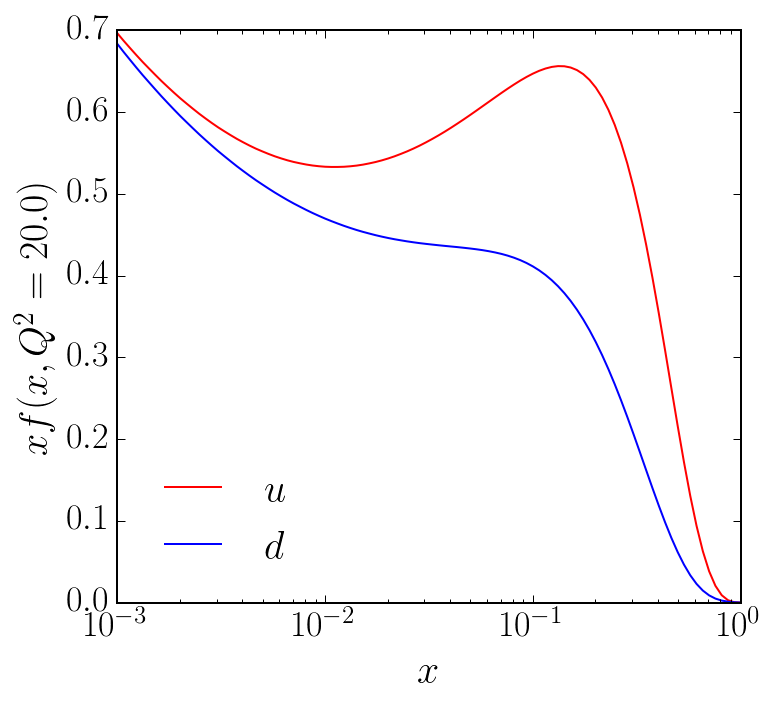

In [12]:
nrows,ncols=1,1
py.figure(figsize=(ncols*5.5,nrows*5))
ax=py.subplot(nrows,ncols,1)
X=10**np.linspace(-3,0,100)
Q2=20.0
xu =np.array([x*distro.get_PDF('u',x,Q2) for x in X])
xub=np.array([x*distro.get_PDF('ub',x,Q2) for x in X])
xd =np.array([x*distro.get_PDF('d',x,Q2) for x in X])
xdb=np.array([x*distro.get_PDF('db',x,Q2) for x in X])
ax.plot(X,xu,'r-',label=r'$u$')
ax.plot(X,xd,'b-',label=r'$d$')
ax.legend(frameon=0,fontsize=20)
ax.set_xlabel(r'$x$',size=20)
ax.set_ylabel(r'$xf(x,Q^2=%0.1f)$'%Q2,size=20)
ax.legend(frameon=0,fontsize=20,loc=3)
ax.semilogx()
py.tick_params(axis='both', which='major', labelsize=18)
py.tight_layout()